# Draw worm configurations

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from operator import xor
from worm_simulation import WormSimulation
from bonds import Bonds
from specific_heat import SpecificHeat
from pca import PrincipalComponent
from specific_heat import SpecificHeat
from count_bonds import *
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnchoredText
import matplotlib.offsetbox as offsetbox
#from mpl_toolkits.axes_grid.inset_locator import inset_axes
#from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
#from mpl_toolkits.axes_grid1.inset_locator import mark_inset
#from scipy.signal import find_peaks_cwt

%autoreload 2
%matplotlib notebook
import matplotlib as mpl
label_size = 14
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

Tc =  2./np.log(1+np.sqrt(2))    # critical temperature

## Blocking Function

In [2]:
def block_config(config, double_bonds_val=0):
    L = int(np.sqrt(len(config.flatten()))/2)
    blocked_config = np.zeros((L, L), dtype=int)
    blocked_sites = [(2*i, 2*j) for i in range(L//2) for j in range(L//2)]
    for site in blocked_sites:
        i = site[0]
        j = site[1]
        ext_x_bonds = [config[2*i, 2*j+3], config[2*i+2, 2*j+3]]
        ext_y_bonds = [config[2*i+3, 2*j], config[2*i+3, 2*j+2]]
        if double_bonds_val == 0:
            ext_x_bonds_active = xor(ext_x_bonds[0], ext_x_bonds[1])
            ext_y_bonds_active = xor(ext_y_bonds[0], ext_y_bonds[1])
        else:
            num_active_x_bonds = sum(ext_x_bonds)
            num_active_y_bonds = sum(ext_y_bonds)
            ext_x_bonds_active = 0
            ext_y_bonds_active = 0
            if num_active_x_bonds > 0:
                if num_active_x_bonds == 2:
                    ext_x_bonds_active = double_bonds_val
                if num_active_x_bonds == 1:
                    ext_x_bonds_active = 1
            if num_active_y_bonds > 0:
                if num_active_y_bonds == 2:
                    ext_y_bonds_active = double_bonds_val
                if num_active_y_bonds == 1:
                    ext_y_bonds_active = 1

        active_site = ext_x_bonds_active or ext_y_bonds_active

        blocked_config[i, j] = active_site
        blocked_config[i, j+1] = ext_x_bonds_active
        blocked_config[i+1, j] = ext_y_bonds_active

    for site in blocked_sites:
        i = site[0]
        j = site[1]
        if blocked_config[i, j-1] or blocked_config[i-1, j]:
            blocked_config[site] = 1
    return blocked_config

## Plotting functions

### Plotting unblocked configuration

In [71]:
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
def plot_worm_config(config, save=True, temp=None, lw=5, double_bonds_val=0,
                     grid=False):
    markersize = lw - 0.6
    L = int(np.sqrt(len(config.flatten()))/2)
    if config.shape != (2*L, 2*L):
        config = config.reshape(2*L, 2*L)
        
    fig, ax = plt.subplots(figsize=(8,8))
    major_ticks = np.arange(0, L, 2)
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)
    plt.minorticks_off()
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(24) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(24) 
    
    site_idxs_lattice = [[i,j] for i in range(L) for j in range(L)]
    site_idxs_image = [[2*i,2*j] for i in range(L) for j in range(L)]
    bond_idxs_image = [
        (i, j) for i in range(L) for j in range(L) if (i + j) % 2 == 1
    ]
    lattice_sites = np.zeros((L, L))
    for row in range(L):
        for col in range(L):
            ax.plot(row, col,
                    marker='s', color='slategrey',
                    markersize=markersize-0.5, ls='', zorder=5)
            if config[2*row, (2*col+1) % (2*L)]:
                if col == 15:
                    ax.hlines(row, -0.5, 0,
                              color='slategrey', linestyle='-', 
                              lw=lw, zorder=19)
                ax.plot(col, row, col+1, row,
                        marker='s', color='slategrey',  markersize=markersize, 
                        ls='', zorder=19)
                ax.hlines(row, col + 1, col,
                          color='slategrey', linestyle='-', 
                          lw=lw, zorder=19)
            if config[(2*row+1) % (2*L), 2*col]:
                if row == 15:
                    ax.vlines(col, -0.5, 0, color='slategrey',
                              linestyle='-', lw=lw, zorder=19)
                ax.plot(col, row, col, row + 1,
                        marker='s', color='slategrey',  markersize=markersize,
                        ls='', zorder=19)
                ax.vlines(col, row + 1, row,
                          color='slategrey', linestyle='-', lw=lw, zorder=19)
    if grid:
        xgrid = np.arange(0, 2*L)
        ygrid = np.arange(0, 2*L)
        [ax.hlines(i-1./3, -1, 2*L, color='#8a8a8a', lw=1.) for i in ygrid]
        [ax.hlines(i+1./3, -1, 2*L, color='#8a8a8a', lw=1.) for i in ygrid]
        [ax.vlines(i-1./3, -1, 2*L, color='#8a8a8a', lw=1.) for i in xgrid]
        [ax.vlines(i+1./3, -1, 2*L, color='#8a8a8a', lw=1.) for i in xgrid]
    ax.set_xlim(-0.5, L - 0.5)
    ax.set_ylim(-0.5, L - 0.5)
    plt.tight_layout()
    if save:
        out_dir = '../plots/configurations/unblocked/lattice_{}/'.format(L)
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
        existing = [
            float(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
                    if i.endswith('.png')
        ]
        try:
            latest_num = int(max(existing))
        except ValueError:
            latest_num = 0
        new_num = int(latest_num + 1)
        if temp is not None:
            out_file = out_dir + 'worm_configuration_{}_{}.png'.format(new_num, 
                                                                       temp)
        else:
            out_file = out_dir + 'worm_configuration_{}.png'.format(new_num)
        print("Saving file to: {}".format(out_file))
        plt.savefig(out_file, dpi=600, bbox_inches='tight')
    return fig, ax

### Plotting blocked configuration (overlaid on unblocked config)

In [73]:
def plot_worm_config_blocked(config, unblocked_config=None, save=True, 
                             temp=None, double_bonds_val=0, grid=False):
    L = int(np.sqrt(len(config.flatten()))/2)
    if config.shape != (2*L, 2*L):
        config = config.reshape(2*L, 2*L)
    if len(config.shape) == 1:
        temp = config[0,0]
        config = config[1:].reshape(2*L, 2*L)
    if unblocked_config is None:
        fig, ax = plt.subplots(figsize=(8,8))
        plt.grid(True, xdata=np.arange(2*L), ydata=np.arange(2*L))
        major_ticks = np.arange(0, L, 2)
        ax.set_xticks(major_ticks)
        ax.set_yticks(major_ticks)
        plt.minorticks_off()
    else:
        fig, ax = plot_worm_config(unblocked_config, save=save, 
                                   temp=temp, lw=3, grid=grid)
    
    site_idxs_lattice = [[i,j] for i in range(L) for j in range(L)]
    site_idxs_image = [[2*i,2*j] for i in range(L) for j in range(L)]
    bond_idxs_image = [
        (i, j) for i in range(L) for j in range(L) if (i + j) % 2 == 1
    ]
    lattice_sites = np.zeros((L, L))
    
    dx = 0.2
    x_ll = []
    
    xb_ll = [(i - 0.2) for i in range(0, 2*L, 2)] # shifted lower-left position
    xb_lr = [(i + 0.2) for i in range(1, 2*L, 2)] # shifted lower-right position
    
    xb_tup = zip(xb_ll, xb_lr)
    for idx, i in enumerate(xb_tup):
        for j in range(0, 2*L, 2):
            plt.hlines(j - 0.2, i[0], i[1], color='darkgrey', zorder=1)
            plt.vlines(j - 0.2, i[0], i[1], color='darkgrey', zorder=1)
        for k in range(1, 2*L, 2):
            plt.hlines(k + 0.2, i[0], i[1], color='darkgrey', zorder=1)
            plt.vlines(k + 0.2, i[0], i[1], color='darkgrey', zorder=1)
    
    for row in range(L):
        for col in range(L):
            x_bond_val = config[2*row, (2*col+1) % (2*L)]
            if x_bond_val == 2:
                bond_color='C1'
            if x_bond_val == 1:
                bond_color = '#048ac7'
            
            if x_bond_val:
                if col == L - 1:
                    ax.hlines(2*row + 0.5, -0.5, 0.5,
                              color=bond_color, linestyle='-', 
                              lw=5., zorder=19)
                ax.plot(2*col + 0.5, 2*row + 0.5, 
                        2*(col+1) + 0.5, 2*row + 0.5,
                        marker='s', color=bond_color,  markersize=4.4, 
                        ls='', zorder=19)
                ax.hlines(2*row + 0.5, 2*(col + 1) + 0.5, 2*col + 0.5,
                          color=bond_color, linestyle='-', 
                          lw=5., zorder=19)
                
            y_bond_val = config[(2*row + 1) % (2*L), 2*col]
            if y_bond_val == 2:
                bond_color='C1'
            if y_bond_val == 1:
                bond_color='#048ac7'
                
            if y_bond_val:
                if row == L - 1:
                    ax.vlines(2*col + 0.5, -0.5, 0.5, color=bond_color,
                              linestyle='-', lw=5., zorder=19)
                ax.plot(2*col + 0.5, 2*row + 0.5, 
                        2 * col + 0.5, 2*(row + 1) +0.5,
                        marker='s', color=bond_color,  markersize=4.4,
                        ls='', zorder=19)
                ax.vlines(2*col + 0.5, 2*(row + 1) + 0.5, 2*row + 0.5,
                          color=bond_color, linestyle='-', lw=5., zorder=19)
    ax.set_xlim(-0.5, 2*L - 0.5)
    ax.set_ylim(-0.5, 2*L - 0.5)
    if grid:
        xgrid = np.arange(0, 2*L)
        ygrid = np.arange(0, 2*L)
        [ax.hlines(i-1./3, -1, 2*L, color='#8a8a8a', lw=1.) for i in ygrid]
        [ax.hlines(i+1./3, -1, 2*L, color='#8a8a8a', lw=1.) for i in ygrid]
        [ax.vlines(i-1./3, -1, 2*L, color='#8a8a8a', lw=1.) for i in xgrid]
        [ax.vlines(i+1./3, -1, 2*L, color='#8a8a8a', lw=1.) for i in xgrid]
    plt.tight_layout()
    if save:
        out_dir = ('../plots/configurations/blocked/double_bonds_val_{}/'
                   + 'lattice_{}/').format(double_bonds_val, L)
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
        existing = [
            float(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
                    if i.endswith('.png')
        ]
        try:
            latest_num = int(max(existing))
        except ValueError:
            latest_num = 0
        new_num = int(latest_num + 1)
        if temp is not None:
            out_file = out_dir + 'worm_configuration_{}_{}.png'.format(new_num, 
                                                                       temp)
        else:
            out_file = out_dir + 'worm_configuration_{}.png'.format(new_num)
        print("Saving file to: {}".format(out_file))
        plt.savefig(out_file, dpi=600, bbox_inches='tight')
    return fig, ax

## Helper function for loading configurations

In [74]:
def load_sample_configs(L, temp_str):
    """Use pandas.read_csv() to load configuration data for lattice of size L 
    at temperature 'temp_str, using configs_files_dict.
    """
    if type(temp_str) is not str:
        temp_str = str(temp_str).rstrip('0')
    try:
        configs_dir = '../data/configs/{}_lattice/separated_data/'.format(L)
        configs_files = [
            i for i in os.listdir(configs_dir) if i.endswith('.txt')
        ]
        configs_temps = [
            i.split('_')[-1].rstrip('.txt').rstrip('0') for i in configs_files
        ]
        configs_files_dict = dict(zip(
            configs_temps,  [configs_dir + i for i in configs_files]
        ))
        config_data = pd.read_csv(configs_files_dict[temp_str], header=None,
                                  engine='c', delim_whitespace=True).values
        return config_data
    except:
        print("Unable to locate file. Exiting")
        raise

## Load configurations

In [6]:
configs_dir32 = '../data/configs/32_lattice/separated_data/'
configs_files32 = [i for i in os.listdir(configs_dir32) if i.endswith('.txt')]
configs_temps32 = [
    i.split('_')[-1].rstrip('.txt').rstrip('0') for i in configs_files32
]
configs_files_dict32 = dict(zip(configs_temps32, 
                                [configs_dir32 + i for i in configs_files32]))

In [7]:
configs32 = load_sample_configs(32, 2.)

In [8]:
configs16 = load_sample_configs(16, 2.)

## Plot Worm configurations 

In [9]:
configs16 = load_sample_configs(16, 2.)
config = configs16[0][1:]

In [15]:
x = config.reshape((32, 32))
config_blocked0 = block_config(np.array(x, dtype=int), double_bonds_val=0)
config_blocked1 = block_config(np.array(x, dtype=int), double_bonds_val=1)
config_blocked2 = block_config(np.array(x, dtype=int), double_bonds_val=2)

<IPython.core.display.Javascript object>


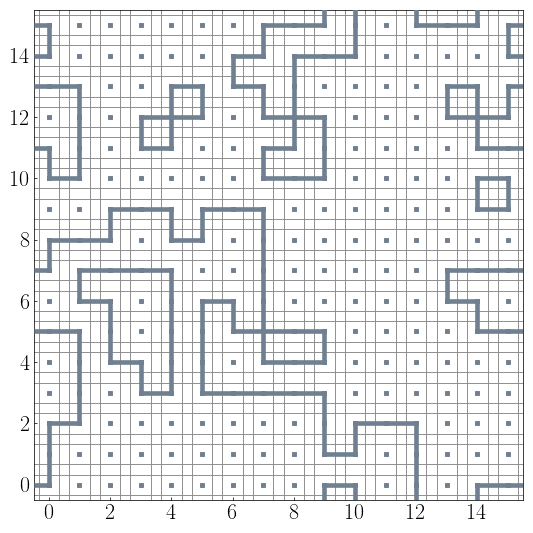

Saving file to: ../plots/configurations/unblocked/lattice_16/worm_configuration_47.png


In [75]:
fig_ub, ax_ub = plot_worm_config(config, save=True, grid=True)

<IPython.core.display.Javascript object>


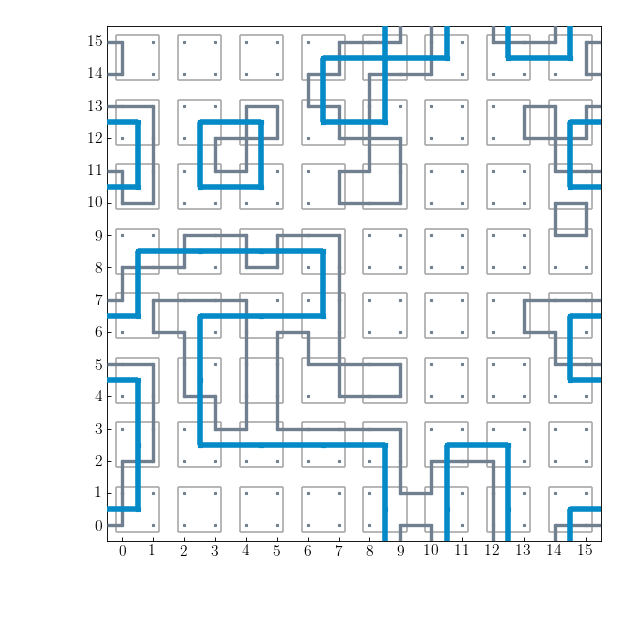

Saving file to: ../plots/configurations/unblocked/lattice_16/worm_configuration_19.png
Saving file to: ../plots/configurations/blocked/double_bonds_val_0/lattice_8/worm_configuration_1.png


In [523]:
fig_b0, ax_b0 = plot_worm_config_blocked(config=config_blocked0, 
                                         unblocked_config=config, 
                                         double_bonds_val=0)

In [ ]:
fig_b1, ax_b1 = plot_worm_config_blocked(config=config_blocked1, 
                                         unblocked_config=config
                                         double_bonds_val=1)

<IPython.core.display.Javascript object>


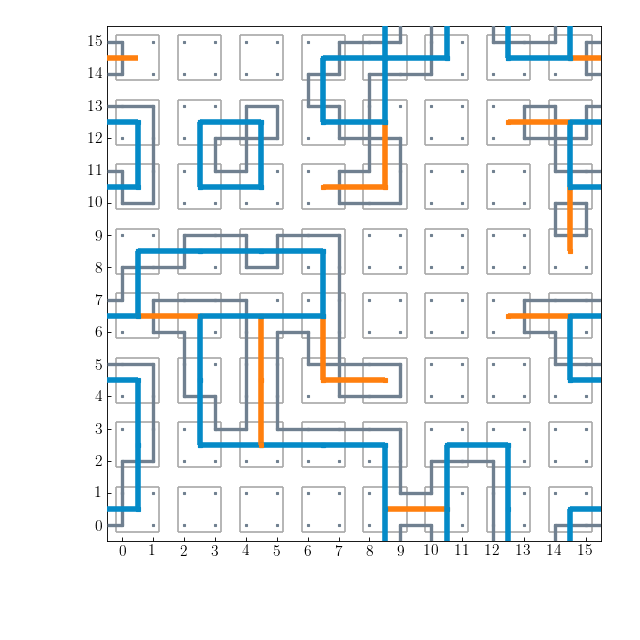

Saving file to: ../plots/configurations/unblocked/lattice_16/worm_configuration_22.png
Saving file to: ../plots/configurations/blocked/double_bonds_val_2/lattice_8/worm_configuration_3.png


In [538]:
fig_b2, ax_b2 = plot_worm_config_blocked(config=config_blocked2, 
                                         unblocked_config=x, 
                                         double_bonds_val=2)

## Represented as images

<IPython.core.display.Javascript object>


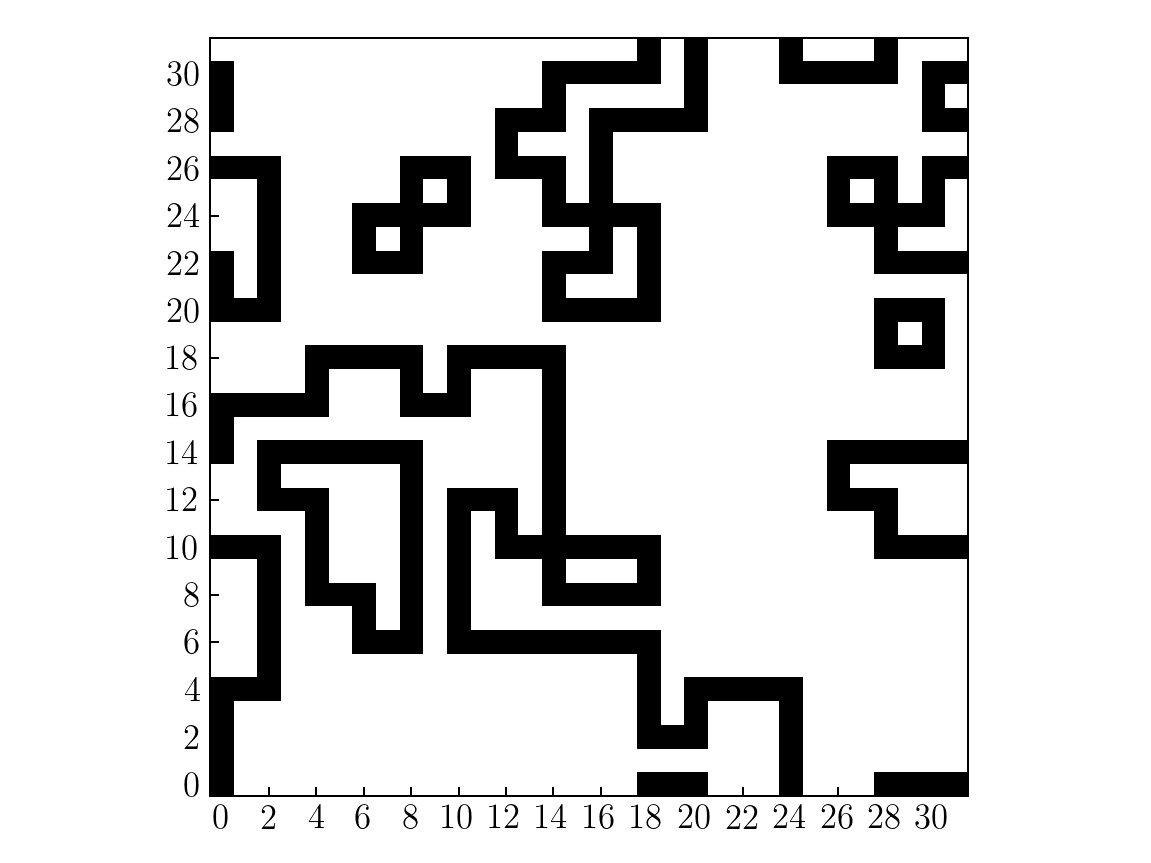

Saving file to: ../plots/configurations/images/unblocked/lattice_16/worm_config_as_image_7.png


In [30]:
L = 16
fig, ax = plt.subplots()
major_ticks = np.arange(0, 2*L, 2)
ax.set_xticks(major_ticks)
ax.set_yticks(major_ticks)
plt.minorticks_off()
plt.tight_layout()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
ax.imshow(config.reshape(2*L, 2*L), cmap='binary', origin='lower')
out_dir = '../plots/configurations/images/unblocked/lattice_{}/'.format(L)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [float(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = int(latest_num + 1)
out_file = out_dir + 'worm_config_as_image_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')

<IPython.core.display.Javascript object>


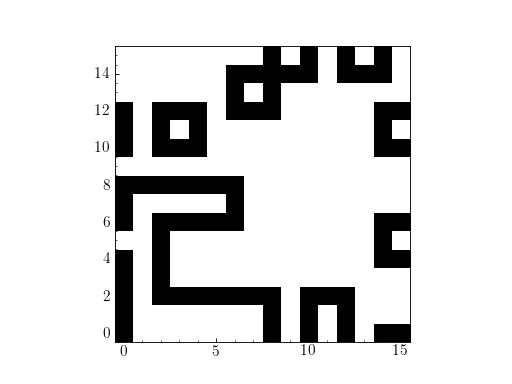

Saving file to: ../plots/configurations/images/blocked/double_bonds_val_0/lattice_16/worm_config_as_image_1.png


In [551]:
fig, ax = plt.subplots()
ax.imshow(config_blocked0, cmap='binary', origin='lower')
out_dir = ('../plots/configurations/images/blocked/'
           + 'double_bonds_val_{}/lattice_{}/'.format(0, L))
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [float(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = int(latest_num + 1)
out_file = out_dir + 'worm_config_as_image_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')

<IPython.core.display.Javascript object>


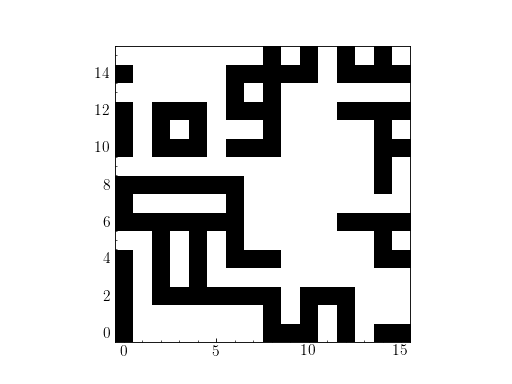

Saving file to: ../plots/configurations/images/blocked/double_bonds_val_1/lattice_16/worm_config_as_image_1.png


In [552]:
fig, ax = plt.subplots()
ax.imshow(config_blocked1, cmap='binary', origin='lower')
out_dir = ('../plots/configurations/images/blocked/'
           + 'double_bonds_val_{}/lattice_{}/'.format(1, L))
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [float(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = int(latest_num + 1)
out_file = out_dir + 'worm_config_as_image_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


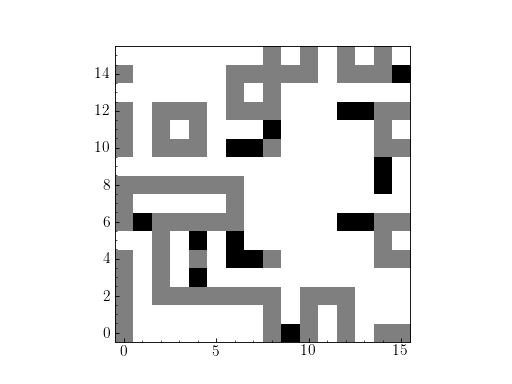

Saving file to: ../plots/configurations/images/blocked/double_bonds_val_2/lattice_16/worm_config_as_image_1.png


In [553]:
fig, ax = plt.subplots()
ax.imshow(config_blocked2, cmap='binary', origin='lower')
out_dir = ('../plots/configurations/images/blocked/'
           + 'double_bonds_val_{}/lattice_{}/'.format(2, L))
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [float(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = int(latest_num + 1)
out_file = out_dir + 'worm_config_as_image_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')